# Task overview
This notebook generates the figure 3 - a basic task overview including a sample image and information on number of samples, number of classes and the imbalance ratio. It requires the `mml-core` library as well as the underlying datasets to be installed.

In [1]:
import logging
import os
from pathlib import Path

current_path = os.getcwd()
DATA_PATH = Path(current_path).parent / 'data'
RESULT_PATH = Path(current_path).parent / 'results'
assert DATA_PATH.exists() and RESULT_PATH.exists()

from IPython import display
from pathlib import Path
from typing import List, Union, Tuple
from PIL import Image

import mml.api
import mml.interactive
from mml.core.data_loading.augmentations.albumentations import AlbumentationsAugmentationModule
import numpy as np
import plotly.graph_objects as go
import plotly.subplots
from omegaconf import OmegaConf
from mml.core.scripts.utils import throttle_logging
from src.prev.data_loading import all_tasks, task_name_map

mml.interactive.init(Path(mml.__file__).parent / 'mml.env')

INFO:mml.core.scripts.utils:Discovered plugins: ['mml-prevalences', 'mml-lsf']!


 _____ ______   _____ ______   ___
|\   _ \  _   \|\   _ \  _   \|\  \
\ \  \\\__\ \  \ \  \\\__\ \  \ \  \
 \ \  \\|__| \  \ \  \\|__| \  \ \  \
  \ \  \    \ \  \ \  \    \ \  \ \  \____
   \ \__\    \ \__\ \__\    \ \__\ \_______\
    \|__|     \|__|\|__|     \|__|\|_______|
         ____  _  _    __  _  _  ____  _  _
        (  _ \( \/ )  (  )( \/ )/ ___)( \/ )
         ) _ ( )  /    )( / \/ \\___ \ )  /
        (____/(__/    (__)\_)(_/(____/(__/
Interactive MML API initialized.


In [2]:
# gather infos
with throttle_logging(level=logging.ERROR, package='mml.interactive.planning'):
    task_infos = mml.interactive.get_task_infos(task_list=all_tasks)
transform_cfg = OmegaConf.create(
    [{'name': 'SmallestMaxSize', 'max_size': 256}, {'name': 'PadIfNeeded', 'min_height': 288, 'min_width': 288},
     {'name': 'Resize', 'height': 256, 'width': 256}])
# gather sample images
imgs = {}
with mml.interactive.default_file_manager() as fm:
    for task in all_tasks:
        ds = mml.api.TaskDataset(root=fm.data_path / fm.task_index[task]['none'],
                                 split=mml.api.DataSplit.TRAIN,
                                 fold=0,
                                 caching_limit=0,
                                 transform=AlbumentationsAugmentationModule(device='cpu', cfg=transform_cfg,
                                                                            is_last=False, is_first=True,
                                                                            tensorize=False, floatify=False,
                                                                            means=None,
                                                                            stds=None)
                                 )
        imgs[task] = ds[-1]['image']  # extract the last image of each dataset

In [4]:
# generate miniatures for each task
for task, img in imgs.items():
    Image.fromarray(img).save(RESULT_PATH / 'miniatures' / f'miniatures_{task}.png')

# information table

In [3]:
def plot_sample_table(task_list: List[str], result_path: Path, proportion: float = 11 / 5,
                      sort_by: str = 'size',
                      stack_attrs: Tuple[str] = ('image', 'name', '#samples', '#classes', 'ir')) -> go.Figure:
    """
    Generates a grid of sample images with annotations for each task.
    """
    # plain task related proportions
    base_rows = int(np.sqrt(len(task_list) * proportion))
    base_cols = int(np.ceil(len(task_list) / base_rows).item())

    # add rows for each stacked item
    n_rows = base_rows * len(stack_attrs)
    # add descriptive column at the beginning
    n_cols = base_cols + 1

    attr_heights = {
        'image': 1. * base_rows / 3,
        'name': 0.5,
        '#samples': 0.25,
        '#classes': 0.25,
        'ir': 0.25
    }
    color_map = {'image': 'black', 'name': 'black', '#samples': '#e6194b', '#classes': '#3cb44b', 'ir': '#4363d8'}

    def sort_func(task: str) -> Union[str, float, int]:
        if sort_by == 'size':
            return task_infos.num_samples[task]
        elif sort_by == 'alphabetic':
            return task
        elif sort_by == 'classes':
            return task_infos.num_classes[task]
        elif sort_by == 'domains':
            return str(task_infos.domains[task].value)
        elif sort_by == 'ir':
            return task_infos.imbalance_ratios[task]
        elif sort_by == 'name':
            return task_name_map[task]
        else:
            raise ValueError(f'{sort_by} not a valid sort method')

    sorted_tasks = sorted(task_list, key=sort_func)
    fig = plotly.subplots.make_subplots(rows=n_rows, cols=n_cols, shared_yaxes='all', shared_xaxes='all',
                                        horizontal_spacing=0.005, vertical_spacing=0.005,
                                        row_heights=[attr_heights[attr] for attr in stack_attrs] * base_rows,
                                        column_widths=[1] * n_cols
                                        )
    # fill descriptive column
    for base_idx in range(base_rows):
        for attr_idx, attr in enumerate(stack_attrs):
            if attr == 'image':
                continue
            val = {'name': 'data set<br>name', '#samples': '# samples', '#classes': '# classes', 'ir': 'IR'}[attr]
            row = base_idx * len(stack_attrs) + attr_idx + 1
            fig.add_trace(go.Scatter(), row=row, col=1)
            fig.add_annotation(xref='x domain', yref='y domain', x=0.5, y=0.5, text=f'<b>{val}:</b>', font_size=30,
                               font_color=color_map[attr], showarrow=False, row=row, col=1)
    for task_idx, task in enumerate(sorted_tasks):
        base_row, base_col = divmod(task_idx, base_cols)
        for attr_idx, attr in enumerate(stack_attrs):
            row = base_row * len(stack_attrs) + attr_idx + 1
            col = base_col + 2
            if attr == 'image':
                fig.add_trace(go.Image(z=imgs[task]), row=row, col=col)
            else:
                if attr == 'name':
                    val = task_name_map[task]
                elif attr == '#samples':
                    val = f'{task_infos.num_samples[task] / 1000:.1f}k'
                elif attr == '#classes':
                    val = str(task_infos.num_classes[task])
                elif attr == 'ir':
                    val = f'{task_infos.imbalance_ratios[task]:.1f}'
                else:
                    raise ValueError(attr)
                fig.add_trace(go.Scatter(), row=row, col=col)
                fig.add_annotation(xref='x domain', yref='y domain', x=0.5, y=0.5, text=f'<b>{val}</b>', font_size=30,
                                   font_color=color_map[attr], showarrow=False, row=row, col=col)
    fig.update_layout(autosize=False, width=1800, height=1300 * base_rows / 3)
    fig.update_layout(
        margin=dict(l=1, r=1, b=1, t=1, pad=1),
        paper_bgcolor='white', plot_bgcolor='white')
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False, autorange="reversed")
    fig['layout']['font']['family'] = "NewComputerModern10"
    # fig.write_html(result_path / f'24_sample_table_{sort_by}.html')
    fig.write_image(result_path / f'24_sample_table_{sort_by}.png')
    # fig.write_image(result_path / f'24_sample_table_{sort_by}.pdf')
    return fig

In [4]:
_ = plot_sample_table(task_list=all_tasks, result_path=RESULT_PATH, proportion=3 / 10, sort_by='name')

## Figure 3

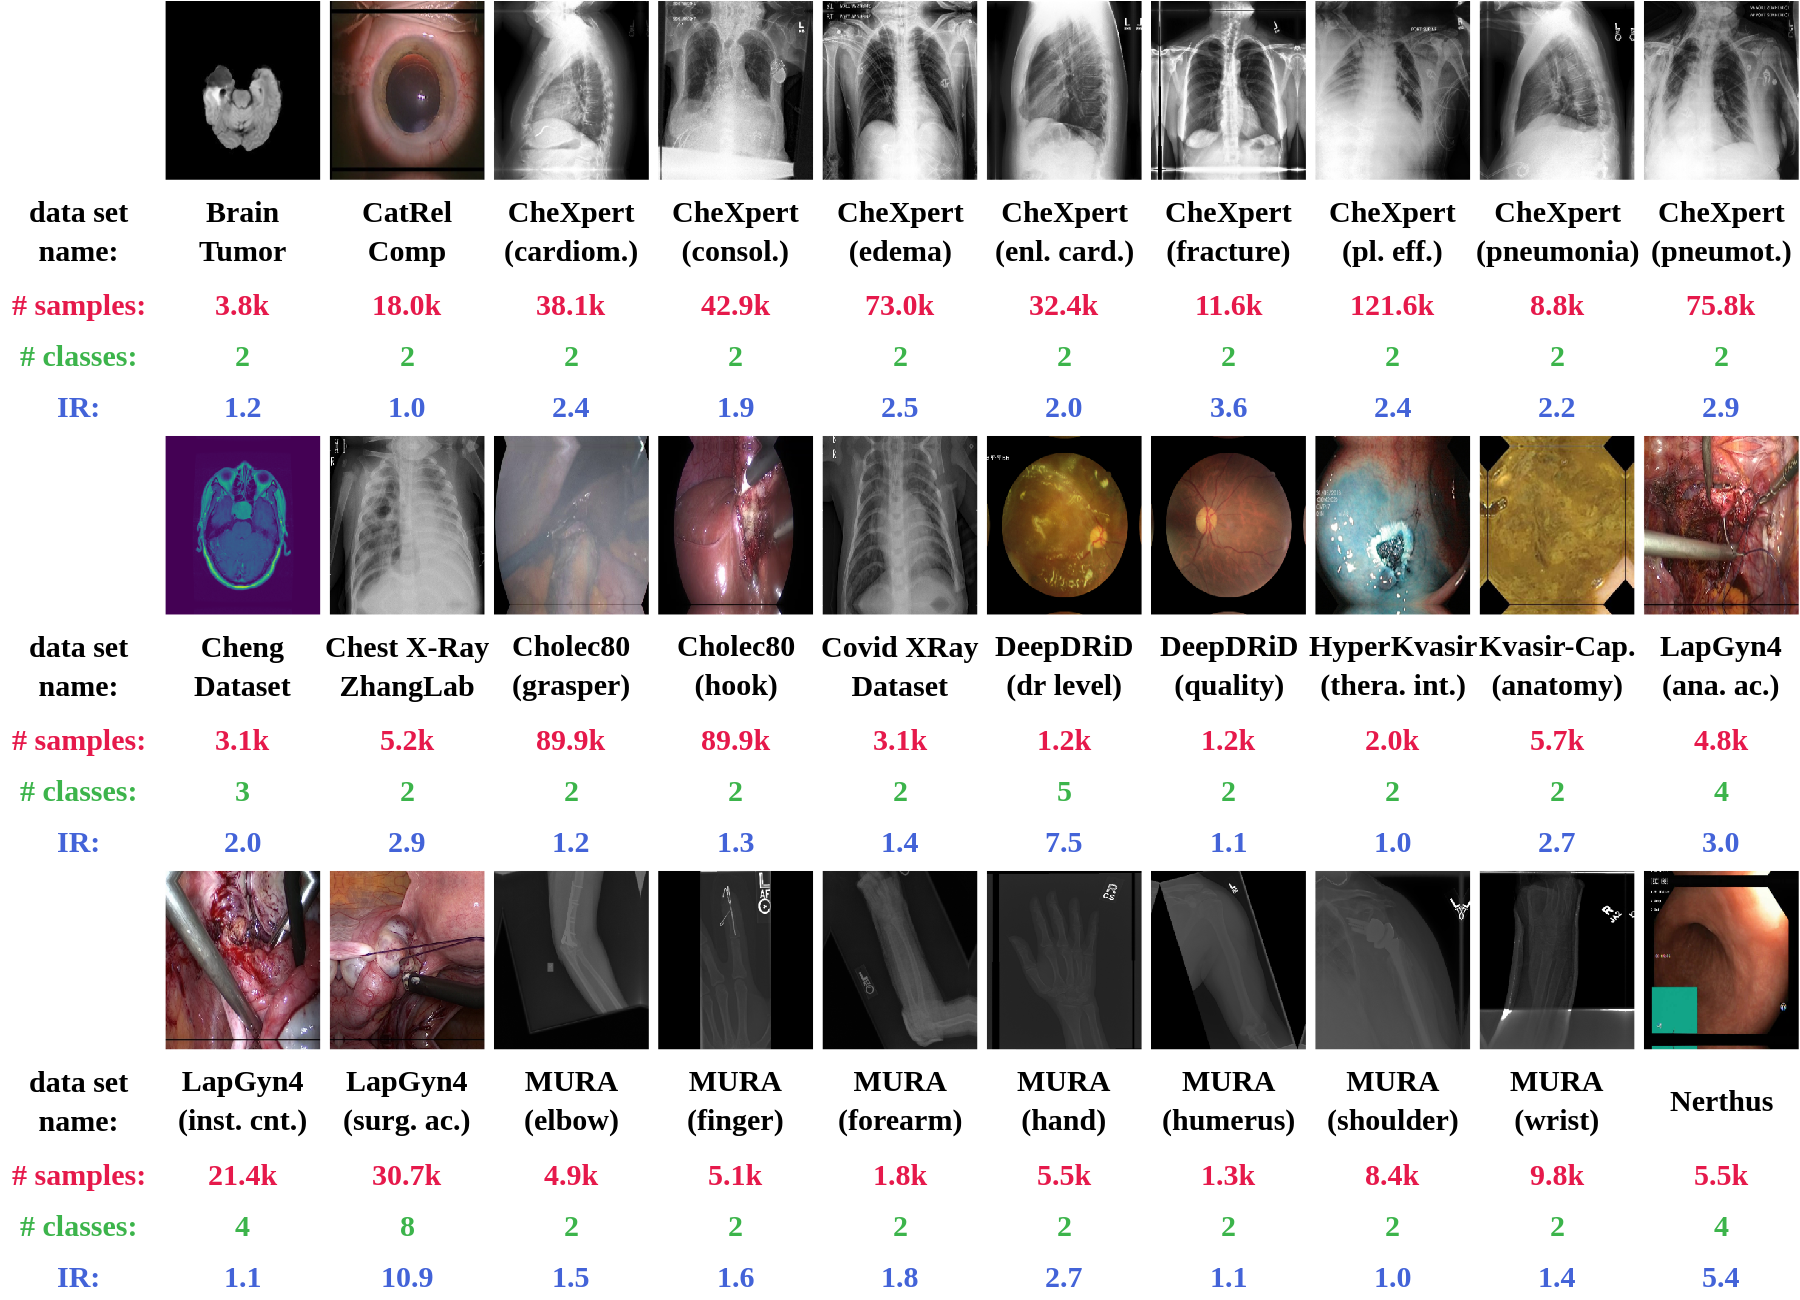

In [5]:
display.Image(RESULT_PATH / '24_sample_table_name.png')